In [1]:
import glob
import tensorflow as tf

In [2]:
images_folder = '../images'

Shape of the image: (1458, 1920, 3)


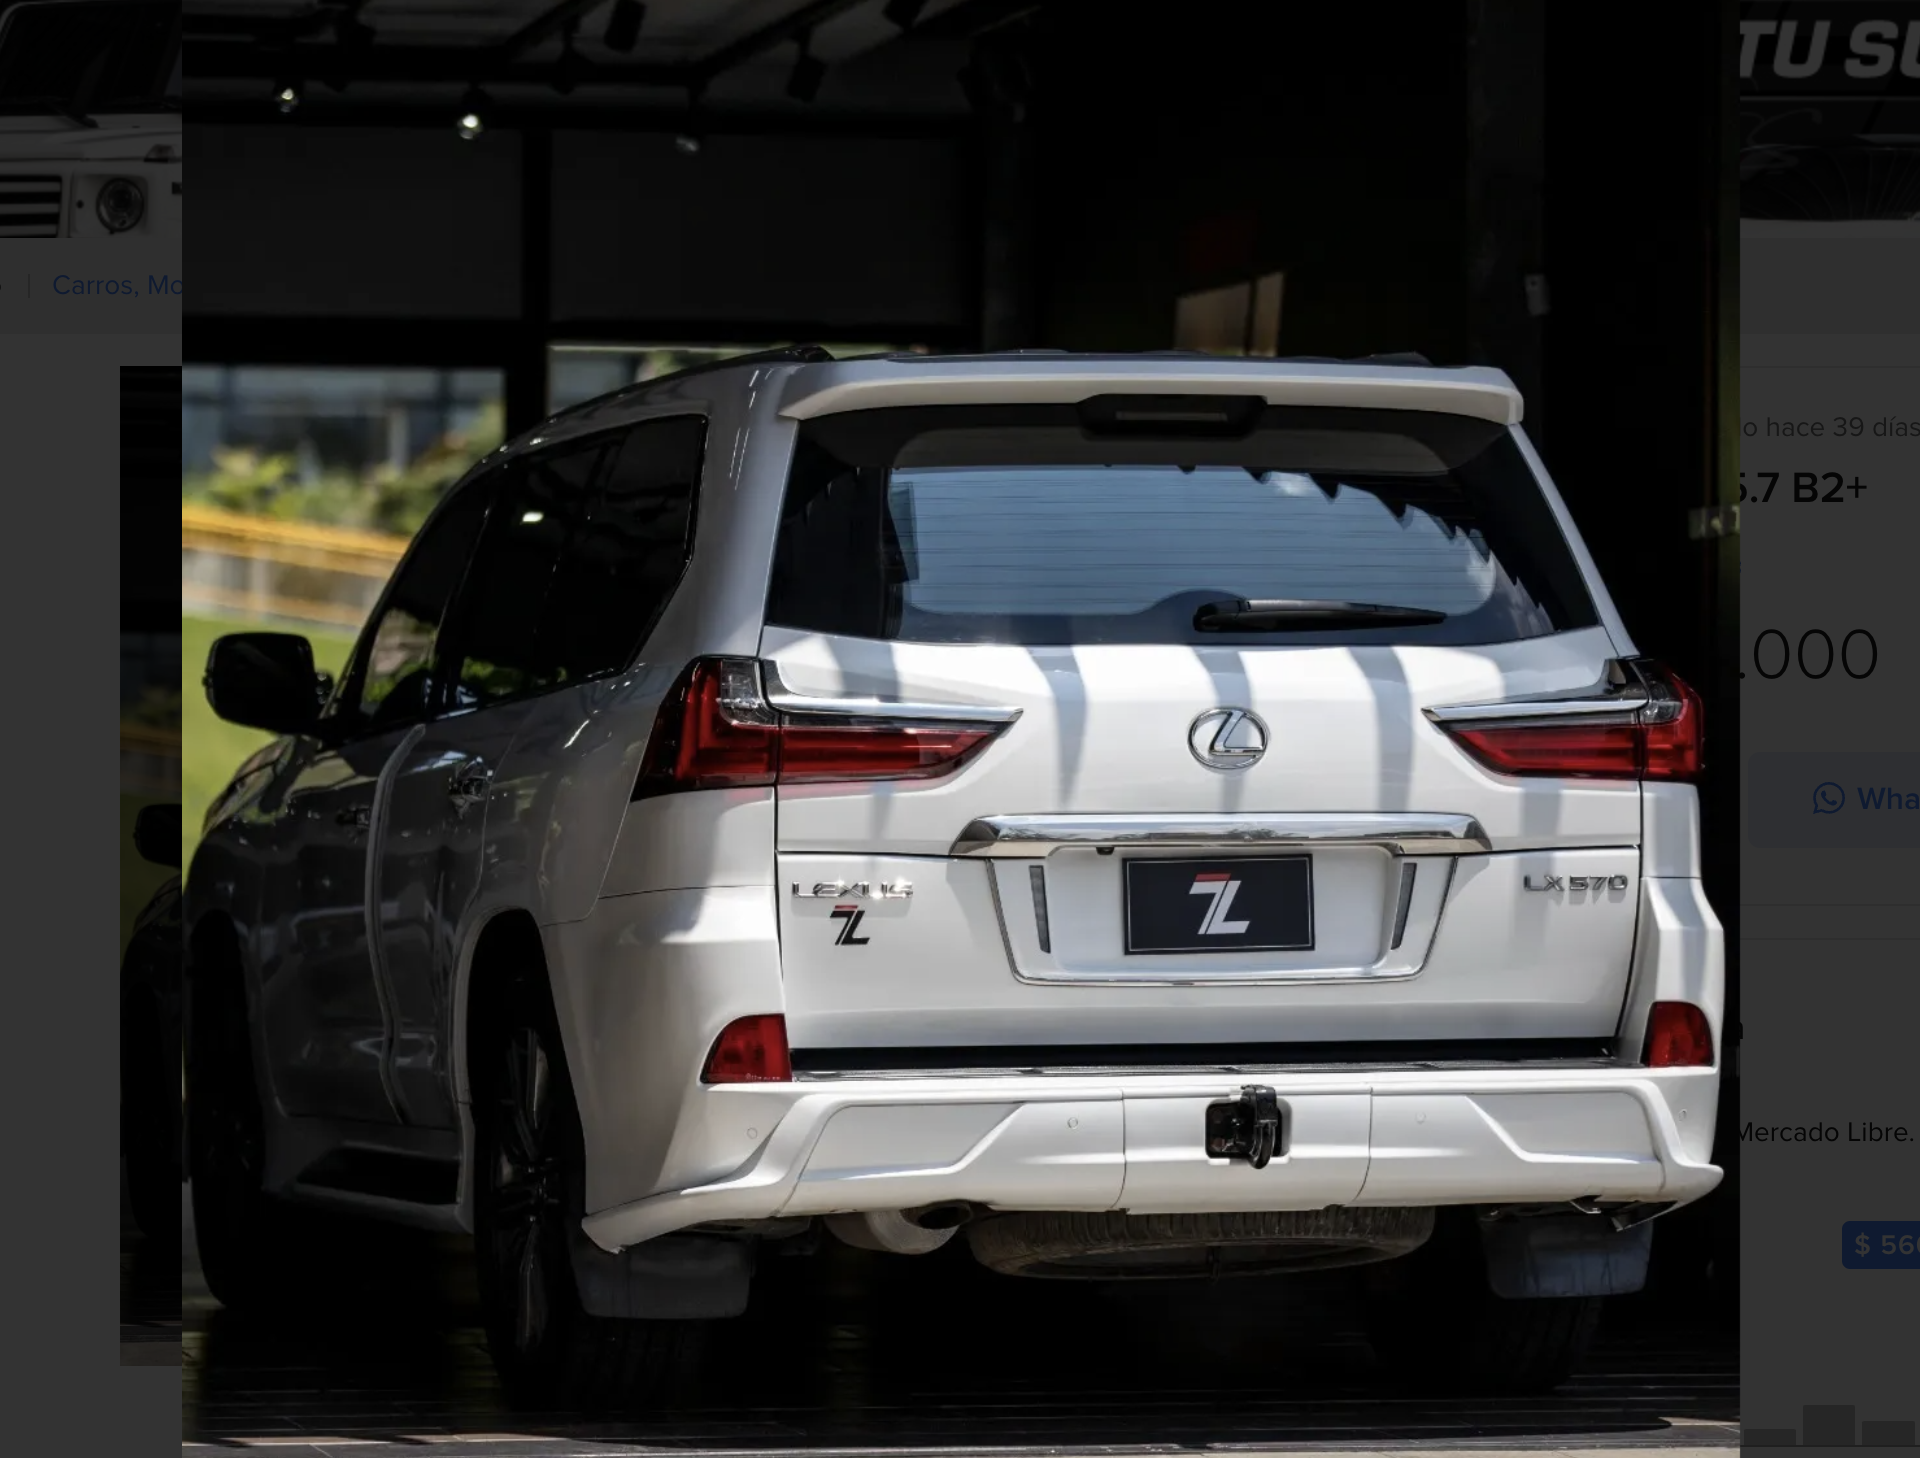

In [3]:
# test load image
image_files = glob.glob(images_folder + '/*/*.png')
image = image_files[0]

pil_image = tf.keras.preprocessing.image.load_img(image)
tf_image = tf.keras.preprocessing.image.img_to_array(pil_image)
print(f'Shape of the image: {tf_image.shape}')
pil_image

The image has a big resolution (1920 x 1458 x 3) which needs to be reduced for computational purposes.

In [4]:
# callback
class AccReached(tf.keras.callbacks.Callback):
  def __init__(self):
    pass
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.95):
      print("\nReached 95% accuracy so cancelling training!")
      self.model.stop_training = True


In [5]:
# import images
train_images = tf.keras.preprocessing.image_dataset_from_directory(
  images_folder,
  labels='inferred',
  image_size=(256, 256),
  batch_size=8,
  shuffle=True,
  validation_split=0.2,
  subset='training',
  seed=42,
)
validation_images = tf.keras.preprocessing.image_dataset_from_directory(
  images_folder,
  labels='inferred',
  image_size=(256, 256),
  batch_size=8,
  shuffle=False,
  validation_split=0.2,
  subset='validation',
  seed=42,
)
labels = train_images.class_names
train_images = train_images.map(lambda x, y: (x / 255.0, y))
validation_images = validation_images.map(lambda x, y: (x / 255.0, y))

Found 1555 files belonging to 3 classes.
Using 1244 files for training.
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Found 1555 files belonging to 3 classes.
Using 311 files for validation.


2022-11-04 17:53:17.530887: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-04 17:53:17.531650: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
model = tf.keras.models.Sequential([
    # tf.keras.layers.Conv2D(8, (3,3), activation='relu', input_shape=(256, 256, 3)),
    # tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    # tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [7]:
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer=tf.optimizers.SGD(learning_rate=0.001),
  metrics=['accuracy'],
)

In [8]:
history = model.fit(
  train_images.repeat(),
  steps_per_epoch=156,
  epochs=20,
  verbose=1,
  callbacks=[AccReached()],
  validation_data=validation_images,
)

Epoch 1/20


2022-11-04 17:53:28.989471: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-04 17:53:29.661662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


156/156 [==============================] - ETA: 0s - loss: 0.9292 - accuracy: 0.5932

2022-11-04 17:53:42.893806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


156/156 [==============================] - 16s 94ms/step - loss: 0.9292 - accuracy: 0.5932 - val_loss: 0.3927 - val_accuracy: 0.9968
Epoch 2/20
156/156 [==============================] - 15s 93ms/step - loss: 0.7891 - accuracy: 0.6752 - val_loss: 0.4502 - val_accuracy: 0.8907
Epoch 3/20
156/156 [==============================] - 16s 97ms/step - loss: 0.7233 - accuracy: 0.7170 - val_loss: 0.2583 - val_accuracy: 0.9646
Epoch 4/20
156/156 [==============================] - 15s 91ms/step - loss: 0.6706 - accuracy: 0.7428 - val_loss: 0.1752 - val_accuracy: 0.9775
Epoch 5/20
156/156 [==============================] - 15s 90ms/step - loss: 0.6154 - accuracy: 0.7645 - val_loss: 0.1752 - val_accuracy: 0.9711
Epoch 6/20
156/156 [==============================] - 15s 94ms/step - loss: 0.5709 - accuracy: 0.7661 - val_loss: 0.3649 - val_accuracy: 0.8650
Epoch 7/20
156/156 [==============================] - 16s 96ms/step - loss: 0.5276 - accuracy: 0.7966 - val_loss: 0.1243 - val_accuracy: 0.9839
Epo

In [ ]:
# prediction
new_image = image_files[50]
pil_image = tf.keras.preprocessing.image.load_img(new_image, target_size=(256, 256))
tf_image = tf.keras.preprocessing.image.img_to_array(pil_image)
probs = model.predict(tf_image.reshape(1, 256, 256, 3))
print(f'Model prediction: {labels[probs.argmax()]}')
pil_image

In [ ]:
# save the model
model.save('labeling_model.h5')

In [ ]:
labels